# Comparision between classical Matrix Multiplication Algorithm and Tiled Matrix Multiplication

In this practical work we will compare these two algorithms, and check how the memory access impacts in the performance.

These 2 cells will help us to know which hardware have assigned, to decide the block size in iur parallel algorithm.

Sometimes the 256 threads per block (16x16 threads) are the bes compromise solution.

In [ ]:
#Uncomment the follow line if you are running in Google Colaboratory
# !pip install pycuda

Import the necessary modules, as pycuda, numpy and time

In [ ]:
import  numpy  as  np
import  pycuda.autoinit
from    pycuda.compiler import SourceModule
import  pycuda.driver as  drv
import  pycuda.gpuarray as  gpuarray
import  pycuda.tools as gtools
from numpy import linalg as la
import time

# FIRST KERNEL: simple matrices multiplication
This kernel will recive 3 matrices: a and b are the source matrices, and c is where we will store the result.

The size of the matrix a is $m *n$.

The size of the matrix b is $n * o$.

The size of the matrix c is $m * o$.

All three matrices are stored in a row-wise vector. 

Each thread will have assigned one cell position in the matrix c. The formulae for both coordinates are:


$idxY = blockIdx.y*blockDim.y+threadIdx.y$

$idxX = blockIdx.x*blockDim.x+threadIdx.x$



In [ ]:
kernel  =  SourceModule ("""
__global__ void matrix_mult(float* a, 
                            float* b, 
                            float* c, 
                            int m, 
                            int n, 
                            int o) 
{ 
  // a is the vector which represents the matrix_a
  // b is the vector which represents the matrix_b
  // c is the vector where we will store the resulting matrix
  // m is number of rows of matrix a
  // n is the number of columns of matrix a, and number of rows of matrix b
  // o is the number of columns of matrix b
  // First task: Using threadIdx.x, threadIdx.y, blockDim.x, blockDim.y, 
  // blockIdx.x, blockDim.y identify the coordinates x and y in the result matrix
  // implements the matrix multiplication, cell by cell using the conventional code and analyze

  int idxX;
  int idxY;
  int idxZ;
  int offA;

  float s;

  idxY = blockIdx.y*blockDim.y+threadIdx.y; //With this we calculate the row address in target matrix
  idxX = blockIdx.x*blockDim.x+threadIdx.x; //Here we calculate the column address in target matrix


  if ( idxX < o && idxY < m ){    //Here we verify the row address and column address are valid
    idxZ = idxY*o + idxX;         //Here we calculate the target vector address, 
                                  //asuming it is a row wise matrix representation
    s = 0;                        //Initialize the s acumulator

    offA = idxY*n;                //We calculate the offset of row in matrix a row wise representation
                                  //This is to reduce the number of calculae in the next for

    for ( int i =0; i<n; i++)     //Here we run through the a columns, b rows
      s += a[offA+i]*b[(i*o)+idxX];
    
    c[idxZ]=s;
  }
  
}
""")

We fetch the cuda function matrix_mult and assign a python reference.

In [ ]:
matrix_mult= kernel.get_function("matrix_mult")

For the first case, we creates 3 matrices of size 1024 * 1024 (this is for a fair play comparation with the tiled matrix multiplication).

In [ ]:
numRowsA=1024
numColsA=1024
numRowsB=1024
numColsB=1024

In [ ]:
matrix_a=np.random.randn(numRowsA,numColsA).astype(np.float32)
matrix_b=np.random.randn(numRowsB,numColsB).astype(np.float32)
matrix_c=np.zeros((numRowsA,numColsB),dtype=np.float32)

Here, we upload the matrices to the GPU.

In [ ]:
matrix_a_gpu=gpuarray.to_gpu(matrix_a)
matrix_b_gpu=gpuarray.to_gpu(matrix_b)
matrix_c_gpu=gpuarray.to_gpu(matrix_c)

We define a block execution size of 16x16x1 threads. It will allocates 256 threads per block < 1024 which is the most common maximum threads per block.

Additionally, Most GPUs have a multiple core number of 256. This allow us to have the maximum number of blox in execution.

In [ ]:
block_size=(16,16,1) #We take this value to get up to 256 parallel threads per block 
                     #This will allow us to get up to 9 parallel blocks in execution in a K80
                     #10 parallel blocks in execution in a T4
                     #14 parallel blocks in execition in a GTX 1080 Ti
                     #17 parallel blocks in execition in a RTX 2080 Ti

We calculate the number of blocks in x axis we will need, as well the number of blocks in y axis..

In [ ]:
numblocks_x=int(np.ceil(numColsB/16))

In [ ]:
numblocks_y=int(np.ceil(numRowsA/16))

Here, we define the grid size

In [ ]:
grid_size=(numblocks_x,numblocks_y)

And execute our matrices multiplication algorithm.

In [ ]:
start_t = time.time()
matrix_mult(matrix_a_gpu,
            matrix_b_gpu,
            matrix_c_gpu,
            np.int32(numRowsA),
            np.int32(numColsA),
            np.int32(numColsB),
            block=block_size,
            grid=(numblocks_x,numblocks_y))
end_t = time.time()

Calculates the time it uses 

In [ ]:
print("Time processing: {0} seconds".format(end_t-start_t))

And get the C result matrix, to compare with the locally computed result.

In [ ]:
matrix_c_final=matrix_c_gpu.get()

In [ ]:
d = np.matmul(matrix_a,matrix_b)

In [ ]:
MSE = np.sum(np.sum(np.power(matrix_c_final-d,2)))/(d.shape[0]*d.shape[1])

In [ ]:
print("Mean Square Error: {0}".format(MSE))

In [ ]:
la.norm(matrix_c_final-d)

In [ ]:
matrix_c_final[290:299,90:99]

In [ ]:
d[290:299,90:99]

# Analysis
The Problem with the previous code is the memory access is no coalesced.<br>

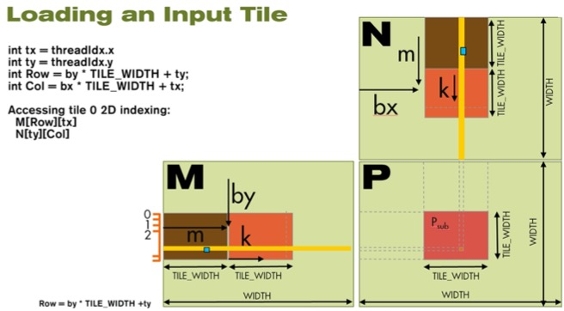


So, there is an algorithm which allows an smart memory handling, using the shared memory tiling: 

In [ ]:
kernel_code_template = """
__global__ void MatrixMulKernel(float *A, float *B, float *C)
{

  const uint wA = %(MATRIX_A_SIZE)s;
  const uint wB = %(MATRIX_B_SIZE)s;  

  // Block index
  const uint bx = blockIdx.x;
  const uint by = blockIdx.y;

  // Thread index
  const uint tx = threadIdx.x;
  const uint ty = threadIdx.y;

  // Index of the first sub-matrix of A processed by the block
  const uint aBegin = wA * %(BLOCK_SIZE)s * by;
  // Index of the last sub-matrix of A processed by the block
  const uint aEnd = aBegin + wA - 1;
  // Step size used to iterate through the sub-matrices of A
  const uint aStep = %(BLOCK_SIZE)s;

  // Index of the first sub-matrix of B processed by the block
  const uint bBegin = %(BLOCK_SIZE)s * bx;
  // Step size used to iterate through the sub-matrices of B
  const uint bStep = %(BLOCK_SIZE)s * wB;

  // The element of the block sub-matrix that is computed
  // by the thread
  float Csub = 0;
  // Loop over all the sub-matrices of A and B required to
  // compute the block sub-matrix
  for (int a = aBegin, b = bBegin;
       a <= aEnd;
       a += aStep, b += bStep) 
    {
      // Shared memory for the sub-matrix of A
      __shared__ float As[%(BLOCK_SIZE)s][%(BLOCK_SIZE)s];
      // Shared memory for the sub-matrix of B
      __shared__ float Bs[%(BLOCK_SIZE)s][%(BLOCK_SIZE)s];

      // Load the matrices from global memory to shared memory
      // each thread loads one element of each matrix
      As[ty][tx] = A[a + wA * ty + tx];
      Bs[ty][tx] = B[b + wB * ty + tx];
      // Synchronize to make sure the matrices are loaded
      __syncthreads();

      // Multiply the two matrices together;
      // each thread computes one element
      // of the block sub-matrix
      for (int k = 0; k < %(BLOCK_SIZE)s; ++k)
        Csub += As[ty][k] * Bs[k][tx];

      // Synchronize to make sure that the preceding
      // computation is done before loading two new
      // sub-matrices of A and B in the next iteration
      __syncthreads();
    }

  // Write the block sub-matrix to global memory;
  // each thread writes one element
  const uint c = wB * %(BLOCK_SIZE)s * by + %(BLOCK_SIZE)s * bx;
  C[c + wB * ty + tx] = Csub;
}
"""


Here, we define the size of our square matrices. This is flaw in this algorithm (check forward).

In [ ]:
# define the (square) matrix size
MATRIX_A_SIZE = 1024
MATRIX_B_SIZE = 1024

# define size of blocks and tiles sub-matrix 
# (we assume that the block size is same as tile size)
TILE_SIZE = 16
BLOCK_SIZE = TILE_SIZE

This is a trick, to replace in our original code the constants MATRIX_A_SIZE, MATRIX_B_SIZE and BLOCK_SIZE, for it values.

It allows us change the matriz sizes without change the original code.

It is not CUDA trick, its a python trick  using strings and % parameters.

In [ ]:
# get the kernel code from the template 
# by specifying the constants MATRIX_A_SIZE, MATRIX_B_SIZE, and BLOCK_SIZE
kernel_code = kernel_code_template % { 
    'MATRIX_A_SIZE': MATRIX_A_SIZE,
    'MATRIX_B_SIZE': MATRIX_B_SIZE,
    'BLOCK_SIZE': BLOCK_SIZE
}

Here,we compile the kernel code, geting the kernel function reference, in matrixmul.

In [ ]:
# compile the kernel code
mod = SourceModule(kernel_code)

Then we have to crate our matrix_a and matrix_b to be used in this algorithm, and upload to the GPU, for this algorithm.

In [ ]:

# create two random square matrices
a_cpu = matrix_a
b_cpu = matrix_b

# compute reference on the CPU to verify GPU computation
c_cpu = np.dot(a_cpu, b_cpu)

Instead to create a host matrix c with zeroes, we can reserve the memory in the GPU, after we can copy the results from the memory to a new local variable.<br/>
This will reduce the amount of data to upload (and the time its taken).

In [ ]:
# transfer host (CPU) memory to device (GPU) memory 
a_gpu = gpuarray.to_gpu(a_cpu) 
b_gpu = gpuarray.to_gpu(b_cpu)

# create empty gpu array for the result (C = A * B)
c_gpu = gpuarray.empty((MATRIX_A_SIZE, MATRIX_B_SIZE), np.float32)

In [ ]:
# get the kernel function from the compiled module
matrixmul = mod.get_function("MatrixMulKernel")

Now, we define the blocksize and grid size parameters.

In [ ]:
block_size=(int(TILE_SIZE),int(TILE_SIZE),1)

In [ ]:
gris_size=(int(np.ceil(MATRIX_A_SIZE/TILE_SIZE)),int(np.ceil(MATRIX_A_SIZE/TILE_SIZE)))

Invokes the matrices multiplication kernel, and measure the timming.

In [ ]:
# call the kernel on the card
start_t = time.time()
matrixmul(
    # inputs
    a_gpu, b_gpu, 
    # output
    c_gpu, 
    # grid of multiple blocks
    grid = grid_size,
    # block of multiple threads
    block = block_size 
    )
end_t = time.time()

In [ ]:
print("Time processing: {0} seconds".format(end_t-start_t))

In [ ]:
c_cpu_final = c_gpu.get()

In [ ]:
MSE = np.sum(np.sum(np.power(c_cpu_final-d,2)))/(d.shape[0]*d.shape[1])

In [ ]:
print("Mean Square Error: {0}".format(MSE))

# PRACTICAL WORK:

Modify the previous code to recieive any dimensional matrices, and be able to multipy them using tiled memory.

Take care about boundaries in the final matrix, and fill with zeroes the memory places where the original matrices are not defined.